## Linear Mixed Effect Modelling for Panel Data

In [1]:
library("tidyverse")
library("lme4")
library("plm")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘plm’


The following objects are masked from ‘package:dplyr’:

    between, lag, lead




The data analysed is historical employment data for various UK firms between 1976 and 1984.

In [2]:
data("EmplUK")
head(EmplUK)

,firm,year,sector,emp,wage,capital,output
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1977,7,5.041,13.1516,0.5894,95.7072
2,1,1978,7,5.600,12.3018,0.6318,97.3569
3,1,1979,7,5.015,12.8395,0.6771,99.6083
4,1,1980,7,4.715,13.8039,0.6171,100.5501
5,1,1981,7,4.093,14.2897,0.5076,99.5581
6,1,1982,7,3.166,14.8681,0.4229,98.6151


In [3]:
EmplUK$firm <- factor(EmplUK$firm)

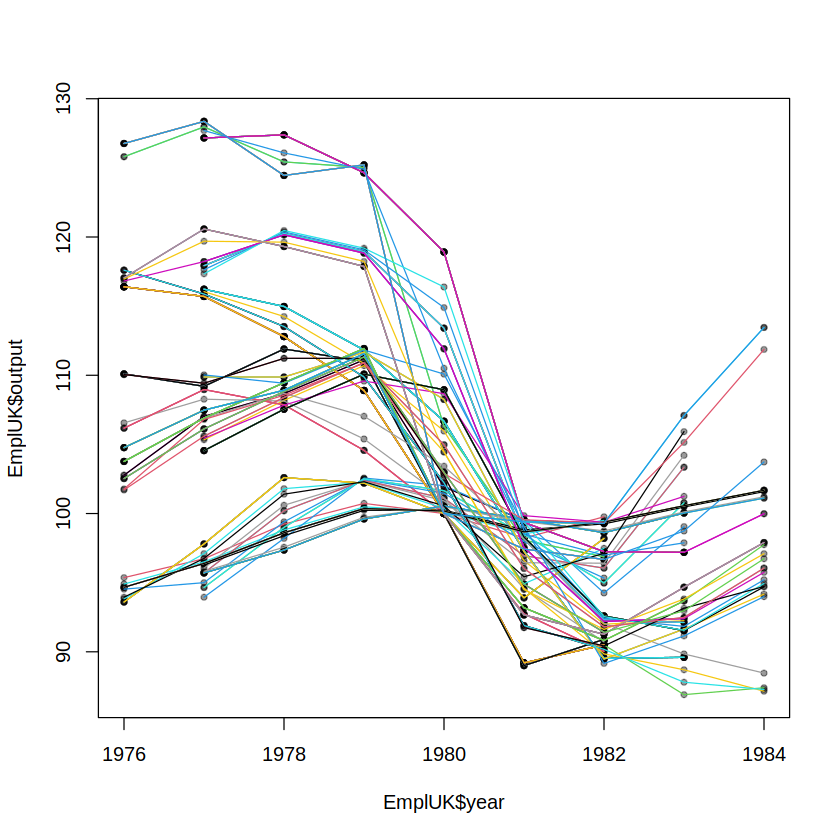

In [4]:
plot(EmplUK$year, EmplUK$output, pch=20, col=rgb(0, 0, 0, alpha=0.4))
pl <- by(EmplUK, EmplUK$firm, function(x) points(x$year, x$output, type="l", col=x$firm[1]))

We observe that different firms have different intercepts. We want to model the output of a firm based on various predictors. First, we consider a simple linear model: for the $i^\text{th}$ firm at time $t=1,\dots,9$, let $Y_{it} = \beta_0 + \beta_1^T x_{it} + \varepsilon_{it}$, where $\varepsilon_{it} \stackrel{\text{i.i.d.}}{\sim} \mathcal{N}(0,\sigma^2)$ and where $x_{it}$ is a vector of the covariates `year`, `emp`, `wage` and `capital`.

In [5]:
EmplUK.lm <- lm(output ~ emp + wage + capital + I(year-1976), data = EmplUK)
summary(EmplUK.lm)


Call:
lm(formula = output ~ emp + wage + capital + I(year - 1976), 
    data = EmplUK)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.744  -4.931  -0.902   4.569  21.879 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    114.178780   1.177084  97.001   <2e-16 ***
emp             -0.051217   0.027605  -1.855   0.0638 .  
wage             0.007648   0.043806   0.175   0.8614    
capital          0.048791   0.069774   0.699   0.4845    
I(year - 1976)  -2.815437   0.109997 -25.596   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.774 on 1026 degrees of freedom
Multiple R-squared:  0.3904,	Adjusted R-squared:  0.388 
F-statistic: 164.3 on 4 and 1026 DF,  p-value: < 2.2e-16


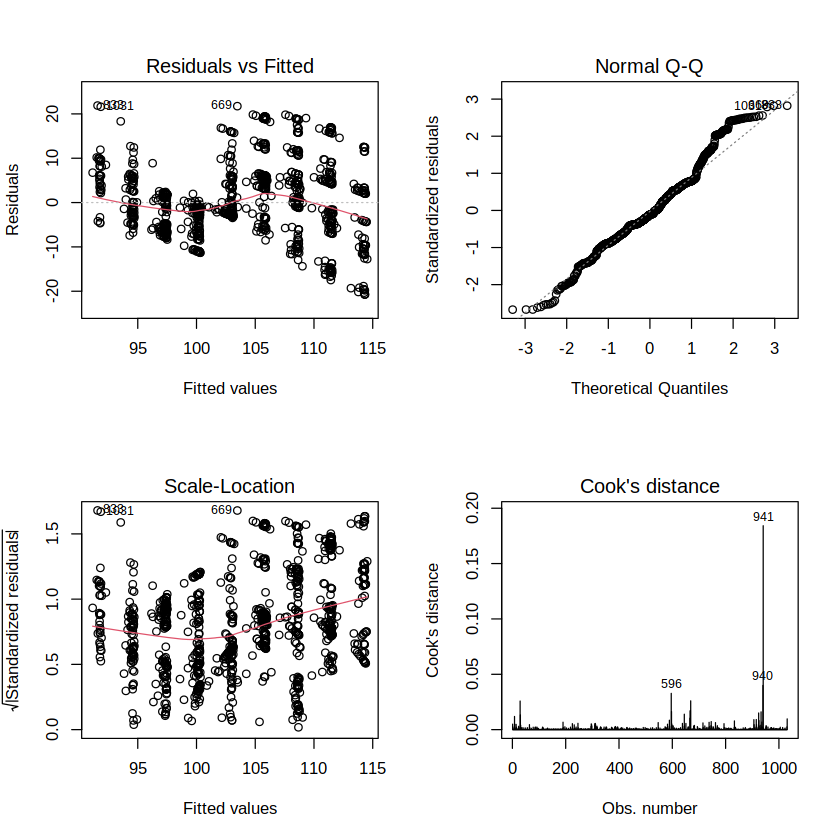

In [6]:
old_par <- par(mfrow = c(2,2))
plot(EmplUK.lm, which = c(1,2,3,4))
par(old_par)

Although there are no obvious issues with the above diagnostics, it is still reasonable to expect to find a better model by explicitly accounting for different firms. We could include `firm` as a categorical variable in the regression, but this adds many more parameters to the model. Since we are not interested in the exact parameter estimates of `firm` (but instead the relationship between `output` and other variables), we can use a random effect model instead:

$$
Y_{it} = \beta_0 + u_i + \beta_1^Tx_{it} + \varepsilon_{it}, \:\: \varepsilon_{it} \stackrel{\text{i.i.d.}}{\sim} \mathcal{N}(0,\sigma^2), \:\: u_i \stackrel{\text{i.i.d.}}{\sim} \mathcal{N}(0,\tau^2).
$$

In [7]:
EmplUK.lme <- lmer(output ~ emp + wage + capital + I(year-1976) + (1 | firm), data = EmplUK, REML=FALSE)
summary(EmplUK.lme)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: output ~ emp + wage + capital + I(year - 1976) + (1 | firm)
   Data: EmplUK

     AIC      BIC   logLik deviance df.resid 
  7068.0   7102.6  -3527.0   7054.0     1024 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.49543 -0.69660  0.00124  0.70855  2.94319 

Random effects:
 Groups   Name        Variance Std.Dev.
 firm     (Intercept) 13.47    3.670   
 Residual             47.00    6.856   
Number of obs: 1031, groups:  firm, 140

Fixed effects:
                Estimate Std. Error t value
(Intercept)    115.10981    1.56026  73.776
emp             -0.05237    0.04075  -1.285
wage            -0.02275    0.06056  -0.376
capital          0.10130    0.10423   0.972
I(year - 1976)  -2.90627    0.09993 -29.083

Correlation of Fixed Effects:
            (Intr) emp    wage   capitl
emp         -0.267                     
wage        -0.932  0.179              
capital      0.162 -0.824 -0.145       
I(ye

The estimates for $\sigma$ and $\tau$ are
$$
\hat{\sigma} = 6.856, \:\: \hat{\tau} = 3.670.
$$

We can view the simple linear model as a limiting case of the mixed effect model with $\tau = 0$. If the likelihood ratio test were valid, we could compare the following likelihood ratio statistic to a $\chi^2_1$ distribution:

In [8]:
lrstat <- 2*(logLik(EmplUK.lme)[1] - logLik(EmplUK.lm)[1])
lrstat

[1] 95.65166

However, there are no guarantees that the likelihood ratio test is valid here since the linear model is a limiting case rather than a special case. Instead, we can use **parametric bootstrap**. We assume that the simpler linear model is the true model, and then generate an empirical distribution of the likelihood test statistic under both models. If the null model is true, the MLE parameters in the linear mixed effect model should be close to those of the simple linear model. For large `B`, the empirical distribution in `lrstatboots` should be close to that of the likelihood ratio test statistic under the null hypothesis.

In [ ]:
set.seed(1)

B <- 100
lrstatboots <- rep(0,B) 

attach(EmplUK)

for (b in 1:B){
    output_boots <- 114.178780 - 0.051217 * emp + 0.007648 * wage + 0.048791 * capital - 2.815437 * (year - 1976) + rnorm(nrow(EmplUK), sd=7.774)
    
    boot.lm <- lm(output_boots ~ emp + wage + capital + I(year-1976))
    boot.lme <- lmer(output_boots ~ emp + wage + capital + I(year-1976) + (1 | firm), REML=FALSE)

    # returns singularity warnings as data comes from the null, so no random effects
    lrstatboots[b] <- 2*(logLik(boot.lme)[1] - logLik(boot.lm)[1]) 
}

An approximate $p$-value can now be constructed as follows:

In [10]:
boot.pval <- sum(lrstatboots>lrstat)/B
boot.pval

[1] 0

The bootstrap $p$-value is 0, so highly significant, so we reject the simpler linear model in favour of the alternative random effect model.